In [ ]:
import numpy as np

In [ ]:
atts=np.load("/content/drive/My Drive/att_scores_out/0.npy", allow_pickle=True)

In [ ]:
scores = atts.item().get('vision')
print(len(scores))
for s in scores:
  print(s.shape)

10
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)
(250, 12, 36, 36)


## Language self-attention scores plotting

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn

dataset_path = "/content/drive/My Drive/att_scores_out/test.json"

def get_question_tokens(ques_id):

  with open(dataset_path) as f:
    dataset = json.load(f)

  ques_string = dataset[ques_id]['sent'].lower()
  ques_tokens = []
  ques_tokens.extend(ques_string.split())
  ques_tokens.append('[eos]')

  return ques_tokens

def plot_lang_attention(ques_id, layers, heads):

  sent = get_question_tokens(ques_id)

  for layer in layers:
    for att_head in heads:

      sample = atts.item().get('lang')[layer][ques_id][att_head][1:9, 1:9]

      fig, ax = plt.subplots(figsize=(6,6))
      ax.set_title("Language layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(sent))+0.5, sent, rotation=45, fontsize=12)
      plt.yticks(np.arange(len(sent))+0.3, sent, rotation=45, fontsize=12)
      ax.set_aspect("equal")
      ax.figure.axes[-1].yaxis.label.set_size(20)
      plt.show()

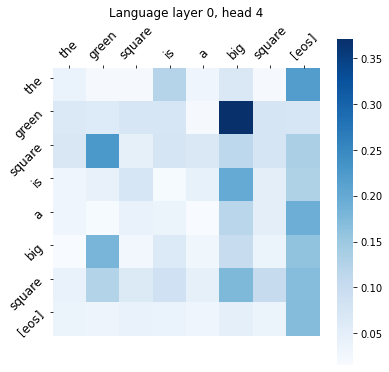

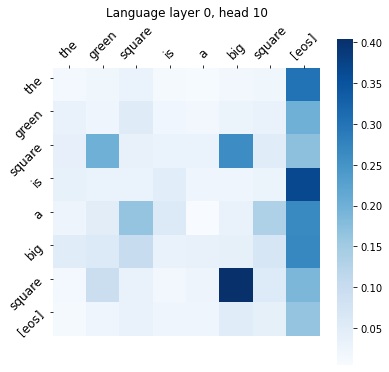

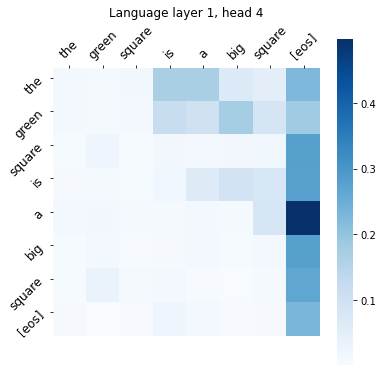

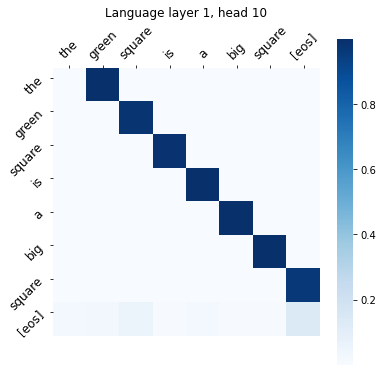

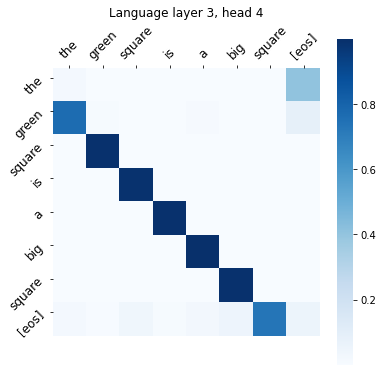

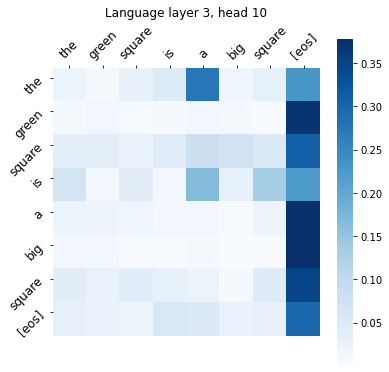

In [ ]:
ques_id = 0
layers = [0,1,3]
heads = [4,10]
plot_lang_attention(ques_id, layers, heads)

## Vision self-attention scores plotting

In [ ]:
!pip install mxnet==1.6.0
!pip install -U d2l -f https://d2l.ai/whl.html

import sys
import csv
import base64
import time
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import image, npx
import numpy as np
import matplotlib.pyplot as plt

npx.set_np()

maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

     |████████████████████████████████| 68.7MB 52kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://d2l.ai/whl.html
     |████████████████████████████████| 61kB 1.5MB/s 


In [ ]:
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]

def load_obj_tsv(fname, topk=None):

    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)
            
            data.append(item)
            if topk is not None and len(data) == topk:
                break
    return data

In [ ]:
rcnn_data = load_obj_tsv("/content/drive/My Drive/out_single/test_obj36.tsv")

Start to load Faster-RCNN detected objects from /content/drive/My Drive/out_single/test_obj36.tsv


In [ ]:
import json

dataset_path = "/content/drive/My Drive/att_scores_out/test.json"

def get_question_tokens(ques_id):

  with open(dataset_path) as f:
    dataset = json.load(f)

  ques_string = dataset[ques_id]['sent'].lower()
  ques_tokens = ['[cls]']
  ques_tokens.extend(ques_string.split())
  ques_tokens.append('[eos]')

  return ques_tokens

def get_image_data(ques_id):

  with open(dataset_path) as f:
    dataset = json.load(f)

  img_id = dataset[ques_id]['img0']

  for datum in rcnn_data:
    if datum['img_id'] == img_id:
      return datum

In [ ]:
def get_detected_labels(ques_id):

  data = get_image_data(ques_id)

  with open("/content/drive/My Drive/att_scores_out/objects_vocab.txt") as f:
    objects = f.readlines()
  objects = [x.strip() for x in objects] 

  with open("/content/drive/My Drive/att_scores_out/attributes_vocab.txt") as f:
    attributes = f.readlines()
  attributes = [x.strip() for x in attributes] 

  detected_obj = []
  detected_attrs = []

  for oid in data['objects_id']:
    detected_obj.append(objects[oid])

  for aid in data['attrs_id']:
    detected_attrs.append(attributes[aid])

  labels = []
  for i, o in enumerate(detected_obj):
    labels.append(str(i) + ': ' + o + ' ' + detected_attrs[i])

  return labels

In [ ]:
def plot_visual_attention(ques_id, layers, heads):

  labels = get_detected_labels(ques_id)

  for layer in layers:
    for att_head in heads:

      sample = atts.item().get('vision')[layer][ques_id][att_head]
      sample = sample[:18, :18]

      fig, ax = plt.subplots(figsize=(6.5,6.5))
      ax.set_title("Vision layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(labels[:18]))+0.5, labels[:18], rotation=90, fontsize=11)
      plt.yticks(np.arange(len(labels[:18]))+0.3, labels[:18], rotation=45, fontsize=11)
      ax.set_aspect("equal")
      #ax.figure.axes[-1].yaxis.label.set_size(25)
      plt.show()

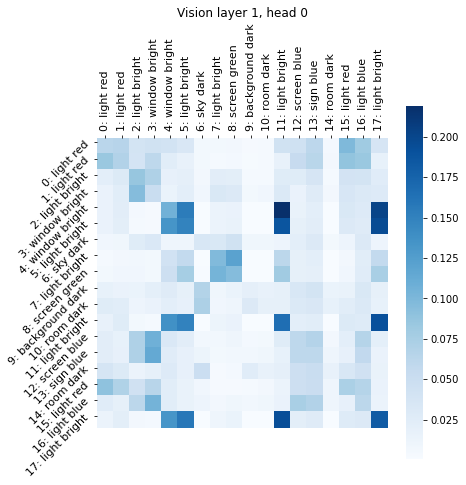

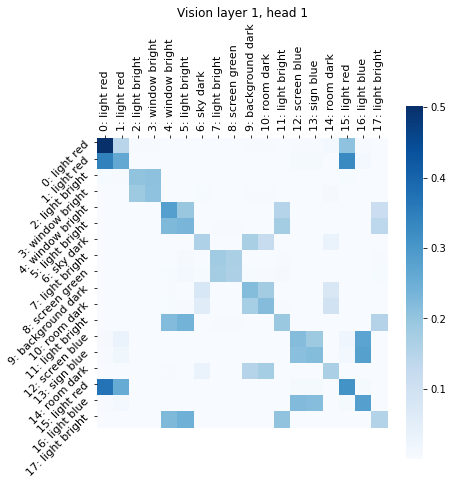

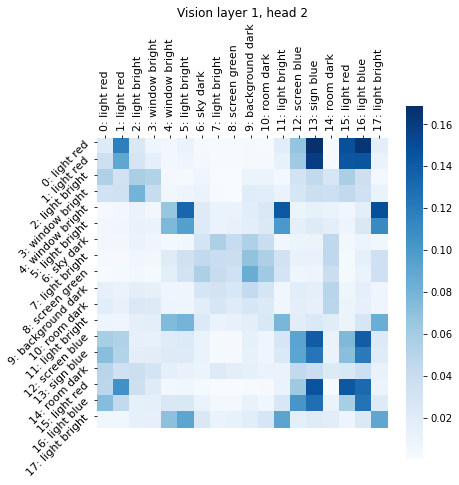

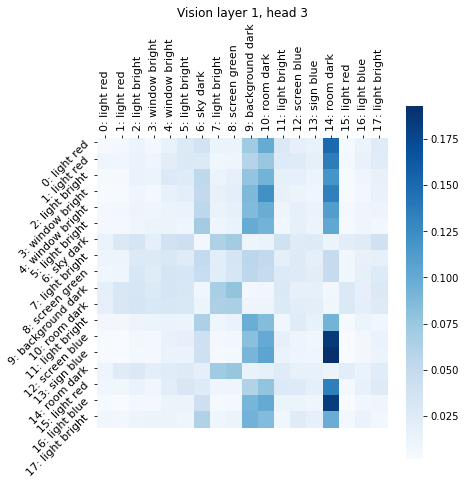

In [ ]:
ques_id = 0
layers = [1]
heads = [0,1,2,3]

plot_visual_attention(ques_id, layers, heads)

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox, color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
            
def show_bboxes_v1(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox, color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0]+rect.get_width(), rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

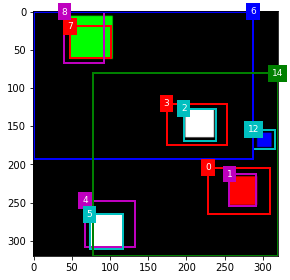

In [ ]:
from operator import itemgetter 

ques_id = 0
img_file = '0.png'

plt.figure(figsize=(4.5,4.5))

img = image.imread(img_file).asnumpy()

labels = get_detected_labels(ques_id)
for i, l in enumerate(labels):
  labels[i] = l.split(': ')[0]

img_feats = get_image_data(ques_id)

to_display = [0,1,2,3,4,5,7,8,12]
fig = d2l.plt.imshow(img)

show_bboxes(fig.axes, itemgetter(*to_display)(img_feats['boxes']),
            itemgetter(*to_display)(labels))

to_display = [6, 14]
show_bboxes_v1(fig.axes, itemgetter(*to_display)(img_feats['boxes']),
            itemgetter(*to_display)(labels))

## Cross-modality attention scores plotting

In [ ]:
def plot_cross_attention(ques_id, img_id, layers, heads):

  labels = get_detected_labels(ques_id)
  sent = get_question_tokens(ques_id)

  for layer in layers:
    for att_head in heads:

      sample = atts.item().get('cross')[layer][img_id][att_head]
    
      if sample.shape[0] == 20:
       
        fig, ax = plt.subplots(figsize=(20,4))
        ax.set_title("Language-vision, layer %d, head %d" % (layer, att_head))
        plt.rcParams['ytick.left'] = True
        sample = sample[:9, :36]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.xticks(np.arange(len(labels))+0.5, labels, rotation=90, fontsize = 14)
        plt.yticks(np.arange(len(sent[:9]))+0.5, sent[:9], rotation=45, fontsize = 14)
        plt.show()
      if sample.shape[0] == 36:
        fig, ax = plt.subplots(figsize=(3,5))
        ax.set_title("Vision-language, layer %d, head %d" % (layer, att_head), fontsize = 14)
        plt.rcParams['ytick.left'] = True
        sample = sample[:20, :9]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.yticks(np.arange(len(labels[:20]))+0.5, labels[:20], rotation=0, fontsize = 14)
        plt.xticks(np.arange(len(sent[:9]))+0.5, sent[:9], rotation=45, fontsize = 14)
        plt.show()

In [ ]:
ques_id = 0
img_id = 0
layers = range(0, 9)
heads = range(0,12)
plot_cross_attention(ques_id, img_id, layers, heads)

Output hidden; open in https://colab.research.google.com to view.

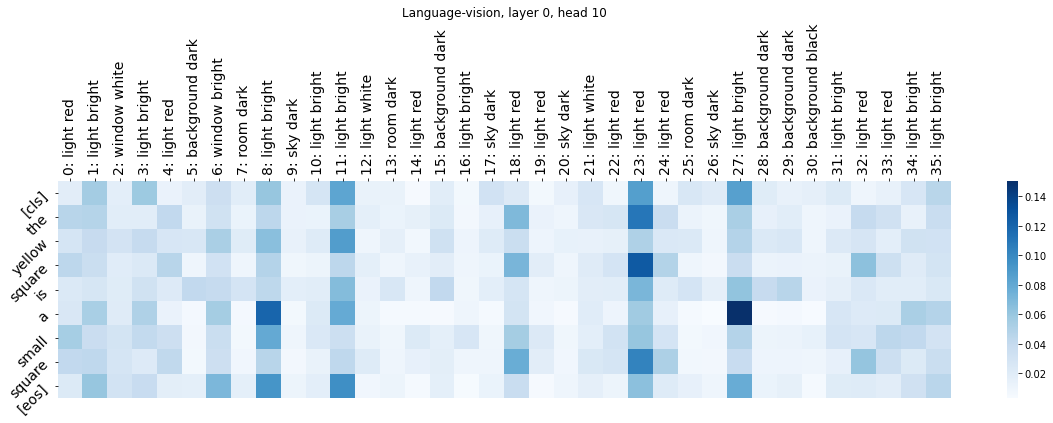

In [ ]:
ques_id = 170
img_id = 170
layers = [0]
heads = [10]
plot_cross_attention(ques_id, img_id, layers, heads)